In [1]:
# !pip install --upgrade autogluon.multimodal

In [2]:
# !pip uninstall torchaudio -y

# !pip install torch torchvision torchaudio

In [3]:
# !pip uninstall -y tensorflow
# !pip install tensorflow-cpu

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.multimodal import MultiModalPredictor # This import should now work
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

print("Bibliotecas importadas correctamente.")

Bibliotecas importadas correctamente.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
images_dir = '/content/drive/My Drive/arcgis-survey-images'


In [7]:
# Verificar si el directorio existe
if not os.path.isdir(images_dir):
    raise FileNotFoundError(f"El directorio '{images_dir}' no existe. Por favor, verifica la ruta.")

In [8]:
# Obtener las clases a partir de los nombres de los subdirectorios
class_names = sorted([d for d in os.listdir(images_dir) if os.path.isdir(os.path.join(images_dir, d))])
print(f"Clases encontradas: {class_names}")

# Recopilar rutas de imágenes y etiquetas
data = []
for class_label in class_names:
    class_dir = os.path.join(images_dir, class_label)
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(class_dir, img_name)
            data.append({'image': img_path, 'label': class_label})

Clases encontradas: ['Chinche salivosa', 'Clororis', 'Hoja sana', 'Roya naranja', 'Roya purpura']


In [9]:
# Crear un DataFrame
df = pd.DataFrame(data)
print(f"Total de imágenes: {len(df)}")

Total de imágenes: 3289


In [10]:
# Dividir en conjuntos de entrenamiento y validación (80% entrenamiento, 20% validación)
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=123)
print(f"Entrenamiento: {len(train_df)} imágenes")
print(f"Validación: {len(valid_df)} imágenes")

Entrenamiento: 2631 imágenes
Validación: 658 imágenes


In [11]:
# Manejo de clases desequilibradas en el conjunto de entrenamiento
class_counts = train_df['label'].value_counts()
print("Conteo de imágenes por clase en el conjunto de entrenamiento:")
print(class_counts)

Conteo de imágenes por clase en el conjunto de entrenamiento:
label
Roya naranja        801
Hoja sana           669
Chinche salivosa    660
Clororis            323
Roya purpura        178
Name: count, dtype: int64


In [12]:
# Encontrar la clase con el mayor número de muestras
max_count = class_counts.max()

In [13]:
# Aumentar las muestras de las clases minoritarias
dfs = []
for class_label, count in class_counts.items():
    df_class = train_df[train_df['label'] == class_label]
    if count < max_count:
        df_class = resample(df_class,
                            replace=True,     # Muestra con reemplazo
                            n_samples=max_count,  # Aumentar a max_count
                            random_state=123)
    dfs.append(df_class)

In [14]:
train_df_balanced = pd.concat(dfs)

In [15]:
# Mezclar el DataFrame balanceado
train_df_balanced = train_df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)
print("Datos de entrenamiento después del balanceo:")
print(train_df_balanced['label'].value_counts())

Datos de entrenamiento después del balanceo:
label
Roya purpura        801
Clororis            801
Roya naranja        801
Hoja sana           801
Chinche salivosa    801
Name: count, dtype: int64


In [16]:
# !python --version


In [17]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [18]:
# !pip uninstall torchvision

In [19]:
# !pip uninstall torchaudio

In [20]:
# !pip show torch


In [21]:
import torch

# Verificar si hay una GPU disponible
if torch.cuda.is_available():
    num_gpus = 1  # Usar 1 GPU
    print("GPU disponible. Usando GPU para el entrenamiento.")
else:
    num_gpus = 0  # Usar CPU
    print("No se encontró GPU. Usando CPU para el entrenamiento.")

GPU disponible. Usando GPU para el entrenamiento.


In [22]:
# !nvcc --version

In [23]:
# Definir el predictor de AutoMM para clasificación
predictor = MultiModalPredictor(problem_type="classification")

In [24]:
# import os
# import multiprocessing

# # Configurar Jupyter para usar un solo hilo
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'

# # Configurar el método de inicio de multiprocesamiento
# multiprocessing.set_start_method('spawn', force=True)

In [25]:
from autogluon.multimodal import MultiModalPredictor

# Inicializar el predictor
predictor = MultiModalPredictor(
    label='label',
    path='autogluon_plague_classifier',
    problem_type='multiclass',
    eval_metric='accuracy'
)

# Ajustar el modelo
predictor.fit(
    train_data=train_df_balanced,
    tuning_data=valid_df,
    time_limit=7200,
    presets="best_quality"
)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          12
Pytorch Version:    2.3.1+cu121
CUDA Version:       12.1
Memory Avail:       80.26 GB / 83.48 GB (96.1%)
Disk Space Avail:   188.45 GB / 235.68 GB (80.0%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/autogluon_plague_classifier
    ```

INFO: Seed set to 0
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart 

model.safetensors:   0%|          | 0.00/788M [00:00<?, ?B/s]

GPU Count: 1
GPU Count to be Used: 1
GPU 0 Name: NVIDIA A100-SXM4-40GB
GPU 0 Memory: 0.44GB/40.0GB (Used/Total)

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name              | Type                            | Params | Mode 
------------------------------------------------------------------------------
0 | model             | TimmAutoModelForImagePrediction | 195 M  | train
1 | validation_metric | MulticlassAccuracy             

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 15: 'val_accuracy' reached 0.60942 (best 0.60942), saving model to '/content/autogluon_plague_classifier/epoch=0-step=15.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 31: 'val_accuracy' reached 0.81003 (best 0.81003), saving model to '/content/autogluon_plague_classifier/epoch=0-step=31.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 47: 'val_accuracy' reached 0.91793 (best 0.91793), saving model to '/content/autogluon_plague_classifier/epoch=1-step=47.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 63: 'val_accuracy' reached 0.91489 (best 0.91793), saving model to '/content/autogluon_plague_classifier/epoch=1-step=63.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 79: 'val_accuracy' reached 0.90426 (best 0.91793), saving model to '/content/autogluon_plague_classifier/epoch=2-step=79.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 95: 'val_accuracy' reached 0.91337 (best 0.91793), saving model to '/content/autogluon_plague_classifier/epoch=2-step=95.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 111: 'val_accuracy' reached 0.91489 (best 0.91793), saving model to '/content/autogluon_plague_classifier/epoch=3-step=111.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 127: 'val_accuracy' reached 0.92857 (best 0.92857), saving model to '/content/autogluon_plague_classifier/epoch=3-step=127.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 143: 'val_accuracy' reached 0.92097 (best 0.92857), saving model to '/content/autogluon_plague_classifier/epoch=4-step=143.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 159: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 175: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 191: 'val_accuracy' reached 0.92097 (best 0.92857), saving model to '/content/autogluon_plague_classifier/epoch=5-step=191.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 207: 'val_accuracy' reached 0.92249 (best 0.92857), saving model to '/content/autogluon_plague_classifier/epoch=6-step=207.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 223: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 239: 'val_accuracy' reached 0.92553 (best 0.92857), saving model to '/content/autogluon_plague_classifier/epoch=7-step=239.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 255: 'val_accuracy' reached 0.93465 (best 0.93465), saving model to '/content/autogluon_plague_classifier/epoch=7-step=255.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 271: 'val_accuracy' reached 0.92857 (best 0.93465), saving model to '/content/autogluon_plague_classifier/epoch=8-step=271.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 287: 'val_accuracy' reached 0.93769 (best 0.93769), saving model to '/content/autogluon_plague_classifier/epoch=8-step=287.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 303: 'val_accuracy' reached 0.93465 (best 0.93769), saving model to '/content/autogluon_plague_classifier/epoch=9-step=303.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 319: 'val_accuracy' reached 0.94073 (best 0.94073), saving model to '/content/autogluon_plague_classifier/epoch=9-step=319.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 335: 'val_accuracy' reached 0.93617 (best 0.94073), saving model to '/content/autogluon_plague_classifier/epoch=10-step=335.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 351: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 367: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 383: 'val_accuracy' reached 0.93769 (best 0.94073), saving model to '/content/autogluon_plague_classifier/epoch=11-step=383.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 399: 'val_accuracy' reached 0.94225 (best 0.94225), saving model to '/content/autogluon_plague_classifier/epoch=12-step=399.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 415: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 431: 'val_accuracy' reached 0.94073 (best 0.94225), saving model to '/content/autogluon_plague_classifier/epoch=13-step=431.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 447: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 463: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 479: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 495: 'val_accuracy' was not in top 3
INFO: Time limit reached. Elapsed time is 2:00:00. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 510: 'val_accuracy' was not in top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/autogluon_plague_classifier")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




In [26]:
# Evaluar el modelo en el conjunto de validación
print("Evaluando el modelo en el conjunto de validación...")
test_metrics = predictor.evaluate(valid_df)
print("Métricas de evaluación:", test_metrics)

Evaluando el modelo en el conjunto de validación...


Predicting: |          | 0/? [00:00<?, ?it/s]

Métricas de evaluación: {'accuracy': 0.9468085106382979}


In [27]:
# Obtener predicciones en el conjunto de validación
print("Obteniendo predicciones en el conjunto de validación...")
valid_predictions = predictor.predict(valid_df)

Obteniendo predicciones en el conjunto de validación...


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Añadir las predicciones al DataFrame de validación
valid_df['pred_label'] = valid_predictions

In [36]:
# Generar el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(valid_df['label'], valid_df['pred_label'], target_names=class_names))

Reporte de clasificación:
                  precision    recall  f1-score   support

Chinche salivosa       0.99      0.95      0.97       165
        Clororis       0.99      0.93      0.96        81
       Hoja sana       0.95      0.99      0.97       168
    Roya naranja       0.90      0.98      0.94       200
    Roya purpura       0.93      0.64      0.76        44

        accuracy                           0.95       658
       macro avg       0.95      0.90      0.92       658
    weighted avg       0.95      0.95      0.94       658



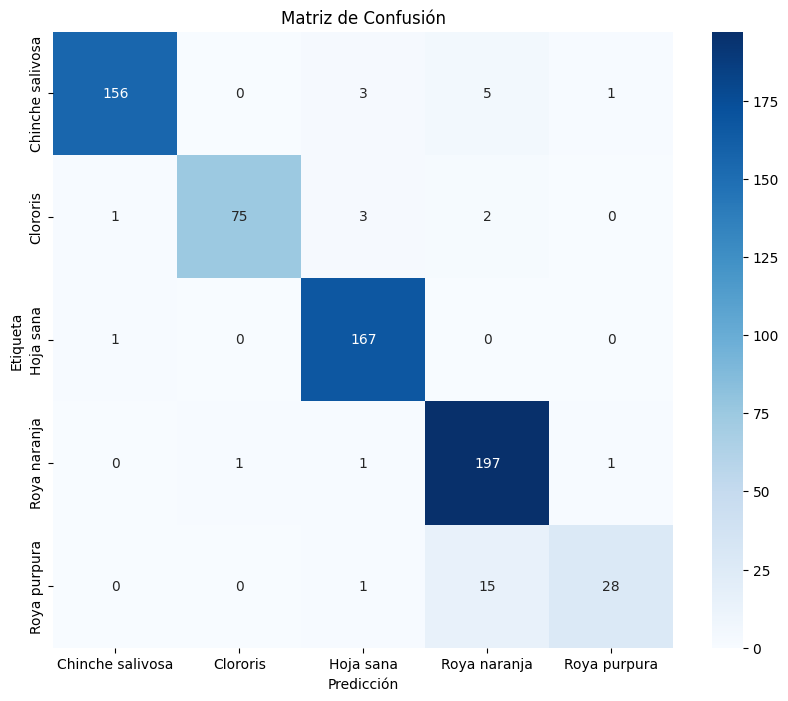

In [37]:
# Crear la matriz de confusión
conf_matrix = confusion_matrix(valid_df['label'], valid_df['pred_label'], labels=class_names)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta')
plt.title('Matriz de Confusión')
plt.show()

In [38]:
def show_predictions(predictor, df, num_images=5):
    samples = df.sample(n=num_images, random_state=42)
    for idx, row in samples.iterrows():
        img_path = row['image']
        true_label = row['label']
        image = Image.open(img_path).convert('RGB')

        # Crear un DataFrame con una sola fila
        input_df = pd.DataFrame({'image': [img_path]})

        # Obtener la predicción
        pred_label = predictor.predict(input_df)

        # Extraer la etiqueta predicha
        predicted_class = pred_label.iloc[0]

        # Mostrar la imagen con las etiquetas
        plt.figure(figsize=(4,4))
        plt.imshow(image)
        plt.title(f"Verdadero: {true_label}\nPredicción: {predicted_class}")
        plt.axis('off')
        plt.show()


Predicting: |          | 0/? [00:00<?, ?it/s]

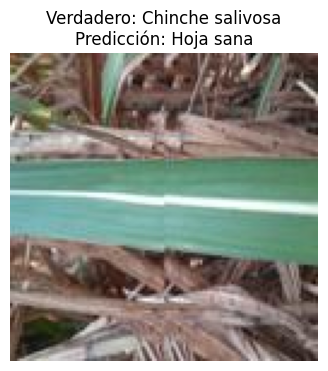

Predicting: |          | 0/? [00:00<?, ?it/s]

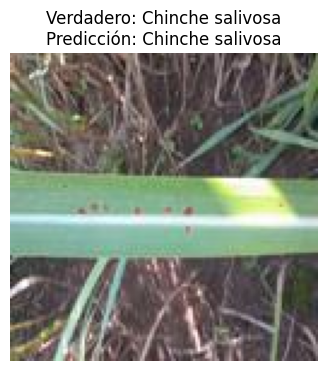

Predicting: |          | 0/? [00:00<?, ?it/s]

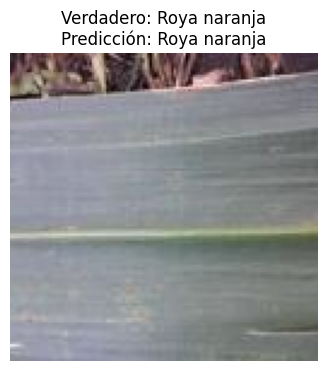

Predicting: |          | 0/? [00:00<?, ?it/s]

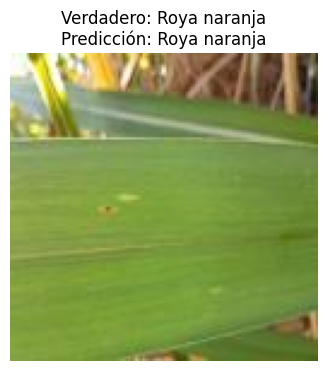

Predicting: |          | 0/? [00:00<?, ?it/s]

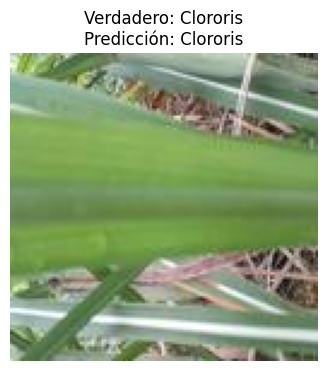

In [39]:
# Mostrar 5 predicciones aleatorias
show_predictions(predictor, valid_df, num_images=5)

In [ ]:
# Guardar el modelo
predictor.save("autogluon_plague_classifier")
print("Modelo guardado en 'autogluon_plague_classifier'.")

In [72]:
print("Ruta donde se guardan los modelos:", predictor.path)


Ruta donde se guardan los modelos: /content/autogluon_plague_classifier


In [51]:
summary = predictor.fit_summary()
print(summary)

{'val_accuracy': 0.9300912022590637, 'training_time': 7413.7320783138275}


In [56]:
predictions = predictor.predict(valid_df, as_pandas=True)
scores = predictor.evaluate(valid_df)
print("Scores for all models:")
print(scores)

TypeError: MultiModalPredictor.predict() got an unexpected keyword argument 'return_pred_proba'

In [57]:
evaluation = predictor.evaluate(valid_df)
print(evaluation)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'accuracy': 0.9468085106382979}


In [62]:
fit_summary = predictor._learner.fit_summary()
print("Resumen del entrenamiento:")
print(fit_summary)

Resumen del entrenamiento:
{'val_accuracy': 0.9300912022590637, 'training_time': 7413.7320783138275}


In [63]:
evaluation = predictor._learner.evaluate(valid_df)
print("Evaluación del modelo:")
print(evaluation)

Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluación del modelo:
{'accuracy': 0.9468085106382979}


In [64]:
predictions = predictor._learner.predict(valid_df)
probabilities = predictor._learner.predict_proba(valid_df)
print("Predicciones:", predictions)
print("Probabilidades:", probabilities)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicciones: 1189            Clororis
186     Chinche salivosa
113     Chinche salivosa
2186        Roya naranja
1784           Hoja sana
              ...       
1117            Clororis
1456           Hoja sana
1866           Hoja sana
552     Chinche salivosa
742     Chinche salivosa
Name: label, Length: 658, dtype: object
Probabilidades:       Chinche salivosa      Clororis     Hoja sana  Roya naranja  Roya purpura
1189      5.827716e-07  9.999982e-01  9.149029e-08  1.104827e-06  2.198700e-08
186       9.999951e-01  5.702978e-08  4.764112e-06  1.476353e-07  2.730572e-09
113       9.999995e-01  2.975621e-09  3.134624e-07  1.084355e-07  3.082554e-08
2186      1.154130e-06  1.880670e-06  1.543748e-07  9.842123e-01  1.578451e-02
1784      1.906556e-07  2.621658e-06  9.998590e-01  1.267511e-04  1.148850e-05
...                ...           ...           ...           ...           ...
1117      3.758987e-07  9.999992e-01  6.190548e-08  3.866965e-07  1.038593e-08
1456      2.370150e-05 

In [66]:
best_score = predictor._learner._best_score
print("Mejor puntaje:", best_score)

Mejor puntaje: 0.9300912022590637


In [67]:
problem_type = predictor._learner.problem_type
print("Tipo de problema:", problem_type)

Tipo de problema: multiclass


In [68]:
validation_metric = predictor._learner.validation_metric
print("Métrica de validación:", validation_metric)

Métrica de validación: accuracy


In [70]:
best_model = predictor._learner._model
print("Mejor modelo:")
print(best_model)

Mejor modelo:
TimmAutoModelForImagePrediction(
  (model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=192, out_features=576, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=192, out_features=192, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_

In [73]:
# Cargar el modelo guardado con AutoMM
loaded_predictor = MultiModalPredictor.load("autogluon_plague_classifier")
print("Modelo cargado desde 'autogluon_plague_classifier'.")

Load pretrained checkpoint: /content/autogluon_plague_classifier/model.ckpt


Modelo cargado desde 'autogluon_plague_classifier'.


In [74]:
# Evaluar nuevamente para verificar
test_metrics = loaded_predictor.evaluate(valid_df)
print("Métricas de evaluación del modelo cargado:", test_metrics)

Predicting: |          | 0/? [00:00<?, ?it/s]

Métricas de evaluación del modelo cargado: {'accuracy': 0.9468085106382979}
